## Data splits ##
Split the data into training, validation and testing data

In [18]:
import os
import sys
import glob
import random
import logging
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import cv2

import albumentations as alb

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData
from computervision.transformations import Transformations, DETRansform

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

# Directory to store the data
dataset_dir = os.path.join(data_dir, 'dentex')

# After extraction from the .tar.gz archive, the images should be on the local fs (see the first notebook)
xrays_dir = os.path.join(dataset_dir, 'cropped')

data_dir: /app/data


In [33]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

## Load the annotations ##

In [3]:
parquet_file_name = 'train_quadrant_enumeration_cropped.parquet'
parquet_file = os.path.join(xrays_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')
display(df.head())

# Create a file name for the data split
split_file_name = f'{os.path.splitext(parquet_file_name)[0]}_dset.parquet'
split_file = os.path.join(xrays_dir, split_file_name)
print(split_file)

# Let's make sure that we have the expected number of images available
# If the image numbers don't match, please run the first three notebooks.
expected_images = len(df['file_name'].unique())
file_list = glob.glob(os.path.join(xrays_dir, '*.png'))
print(f'Found {len(file_list)} images in {xrays_dir}')
print(f'Expected number of images is {expected_images}.')

# We want to be sure that the number of images is correct before we continue
assert expected_images == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})'

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,1473,train_0_12.png,train_0,12,1,1,11,8
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,1473,train_0_12.png,train_0,12,1,2,12,7
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,1473,train_0_12.png,train_0,12,1,3,13,6
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,1473,train_0_12.png,train_0,12,1,4,14,5
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,1473,train_0_12.png,train_0,12,1,5,15,4


/app/data/dentex/cropped/train_quadrant_enumeration_cropped_dset.parquet
Found 2534 images in /app/data/dentex/cropped
Expected number of images is 2534.


In [4]:
# Number of panoramic x-rays for testing and validation 
n_test = 20
n_val = 16

# Start with a sorted list of panoramic x-rays
image_list = sorted(list(df['file_base_name'].unique()))
print(len(image_list))
# Shuffle the list
seed = 123
random.seed(seed)
random.shuffle(image_list)
print(image_list[:5])

# Now we can pick the images for validation and testing
val_image_list = image_list[:n_val]
test_image_list = image_list[n_val+1:n_val+n_test+1]
print(len(val_image_list))
print(len(test_image_list))

# Assign the data sets to the images
df = df.assign(dset='train')
df.loc[df['file_base_name'].isin(val_image_list), 'dset'] = 'val'
df.loc[df['file_base_name'].isin(test_image_list), 'dset'] = 'test'

# Count images and annotations for each data set
for dset in ['train', 'val', 'test']:
    n_base_images = len(df.loc[df['dset'] == dset, 'file_base_name'].unique())
    n_images = len(df.loc[df['dset'] == dset, 'file_name'].unique())
    n_annotations = df.loc[df['dset'] == dset, 'file_name'].shape[0]
    print()
    print(f'{dset.upper()}')
    print(f'Panoramic x-rays: {n_base_images}')
    print(f'Cropped images:   {n_images}')
    print(f'Annotations:      {n_annotations}')

634
['train_185', 'train_143', 'train_36', 'train_609', 'train_242']
16
20

TRAIN
Panoramic x-rays: 598
Cropped images:   2391
Annotations:      34166

VAL
Panoramic x-rays: 16
Cropped images:   63
Annotations:      886

TEST
Panoramic x-rays: 20
Cropped images:   80
Annotations:      1138


In [5]:
# Save the data frame
dset_file_name = f'{os.path.splitext(parquet_file_name)[0].\
    rsplit('_', maxsplit=1)[0]}_dset.parquet'
dset_file = os.path.join(xrays_dir, dset_file_name)
if not os.path.exists(dset_file):
    print(f'Saving data: {dset_file}')
    df.to_parquet(dset_file)
else:
    logger.warning(f'File {dset_file} exists. Skipping.')
display(df.sample(5))

File /app/data/dentex/cropped/train_quadrant_enumeration_dset.parquet exists. Skipping.


,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
1596,"[10, 337, 244, 150]","[[10, 447, 62, 451, 133, 474, 167, 487, 200, 4...",684,827,train_122_14.png,train_122,14,4,8,48,32,train
3174,"[414, 10, 92, 311]","[[452, 321, 434, 284, 425, 204, 414, 15, 461, ...",676,724,train_148_23.png,train_148,23,2,7,27,15,train
33611,"[1386, 12, 198, 227]","[[1386, 60, 1443, 188, 1467, 222, 1505, 239, 1...",445,1594,train_629_12.png,train_629,12,2,8,28,16,train
14887,"[568, 27, 81, 354]","[[590, 312, 589, 374, 602, 381, 636, 378, 649,...",416,996,train_334_12.png,train_334,12,2,2,22,10,train
30162,"[10, 13, 215, 218]","[[72, 231, 128, 216, 175, 184, 216, 142, 225, ...",429,1426,train_575_34.png,train_575,34,4,7,47,31,train


In [6]:
# Making sure that the data sets are distinct
train_images = set(sorted(list(df.loc[df['dset'] == 'train', 'file_name'].unique())))
val_images = set(sorted(list(df.loc[df['dset'] == 'val', 'file_name'].unique())))
test_images = set(sorted(list(df.loc[df['dset'] == 'test', 'file_name'].unique())))

print(f'Training images:   {len(train_images)}')
print(f'Validation images: {len(val_images)}')
print(f'Test images:       {len(test_images)}')

print(train_images.intersection(val_images))
print(train_images.intersection(test_images))
print(val_images.intersection(test_images))

Training images:   2391
Validation images: 63
Test images:       80
set()
set()
set()


### Create validation and test splits from random crops ###

In [8]:
# Load the data frame
print(dset_file)
df = pd.read_parquet(dset_file)
display(df.head())

/app/data/dentex/cropped/train_quadrant_enumeration_dset.parquet


,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,1473,train_0_12.png,train_0,12,1,1,11,8,train
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,1473,train_0_12.png,train_0,12,1,2,12,7,train
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,1473,train_0_12.png,train_0,12,1,3,13,6,train
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,1473,train_0_12.png,train_0,12,1,4,14,5,train
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,1473,train_0_12.png,train_0,12,1,5,15,4,train


In [41]:
# Output directory to save the test images
test_dir = os.path.join(xrays_dir, 'test')
Path(test_dir).mkdir(parents=True, exist_ok=True)

# Set the transformation
im_size = 640
transformation_list = Transformations(image_width=im_size, image_height=im_size).\
    get_transformations('train_1')

# Set the number of transformations per image
n_transforms = 5

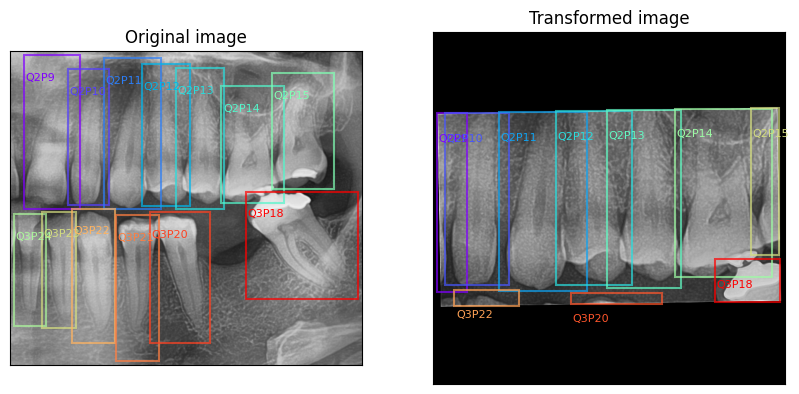

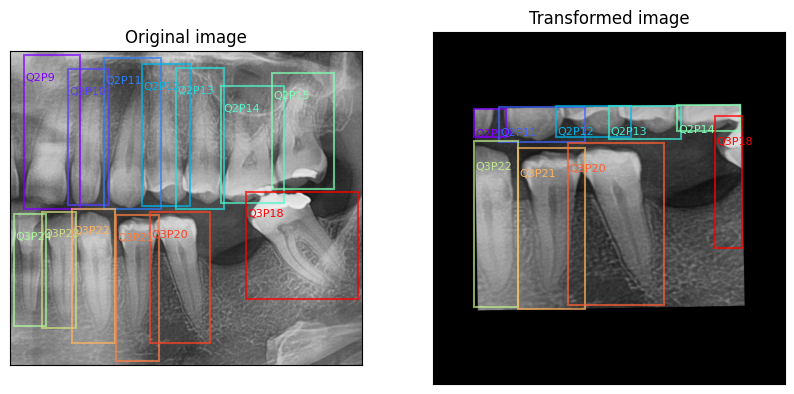

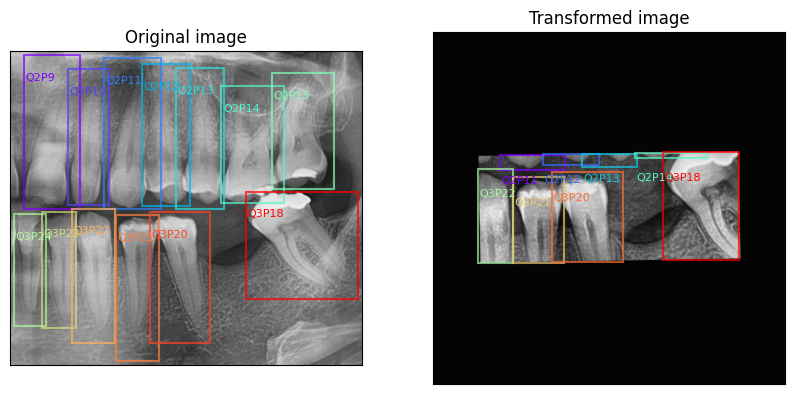

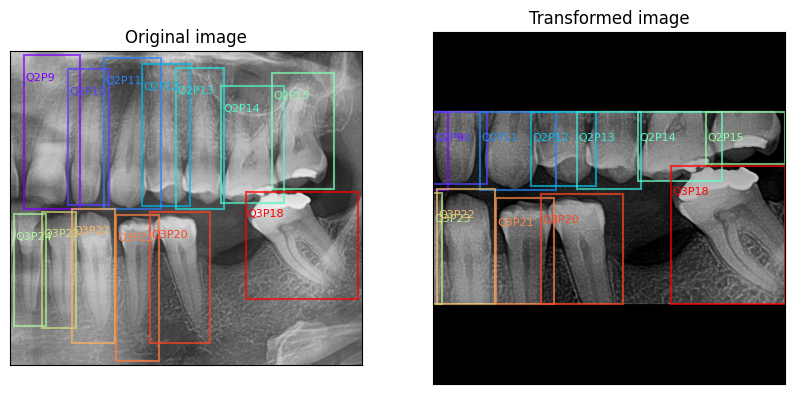

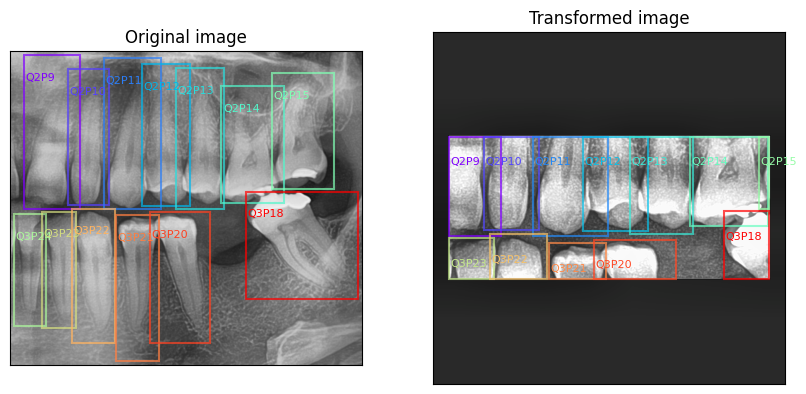

In [67]:
# LOOP OVER DATA SET
dset = 'val'
df_dset = df.loc[df['dset'] == dset].reset_index(drop=True)

# LOOP OVER THE IMAGES IN THE DATA SET
file_name_list = sorted(list(df_dset['file_name'].unique()))
idx = 10
file_name = file_name_list[idx]
file = os.path.join(xrays_dir, file_name)
df_file = df_dset.loc[df_dset['file_name'] == file_name]
file_base_name = df_file['file_base_name'].tolist()[0]
quadrants_base = df_file['quadrants'].tolist()[0]
im = ImageData().load_image(file)
im = ImageData().np2color(im)

# Get the bounding boxes and positions
boxes = df_file['bbox'].tolist()
quadrants = df_file['quadrant'].tolist()
positions = df_file['ada'].tolist()
label_list = [f'Q{q}P{p}' for q, p in zip(quadrants, positions)]

# LOOP OVER THE TRANSFORMATIONS
for t in range(n_transforms):

    # Generate the transform
    detr = DETRansform(transformations=transformation_list)
    output = detr.\
        transform(image=im, bboxes=boxes, label_fields=[quadrants, positions])
    
    # Retrieve the image and annotations of the transformed image
    transformed_im = output['image']
    transformed_box_list = list(output['bboxes'])
    transformed_quadrant_list = list(np.array(output['quadrants']).astype(int))
    transformed_position_list = list(np.array(output['positions']).astype(int))
    transformed_label_list = [f'Q{q}P{p}' for q, p in zip(transformed_quadrant_list, 
                                                          transformed_position_list)]
    
    # Plot the last image with bounding boxes
    # Making sure it is all correct
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0] = plot_boxes(image=im, box_list=boxes, label_list=label_list, ax=ax[0])
    ax[1] = plot_boxes(image=transformed_im, box_list=transformed_box_list, label_list=transformed_label_list, ax=ax[1])
    ax[0].set(title='Original image')
    ax[1].set(title='Transformed image')
    plt.show()

In [68]:
transformed_file_name = f'{os.path.splitext(file_name)[0]}_{str(t).zfill(2)}.png'
transformed_df = pd.DataFrame({'bbox': transformed_box_list,
                               'quadrant': transformed_quadrant_list,
                               'ada': transformed_position_list})
transformed_df = transformed_df.assign(file_name=transformed_file_name,
                                       file_base_name=file_base_name,
                                       quadrants=quadrants_base,
                                       height=transformed_im.shape[1],
                                       width=transformed_im.shape[0])

In [66]:
transformed_image.shape

(640, 640, 3)

In [69]:
transformed_file_name

'train_17_23_04.png'

In [71]:
transformed_df.head(2)

,bbox,quadrant,ada,file_name,file_base_name,quadrants,height,width
0,"[29, 190, 94, 180]",2,9,train_17_23_04.png,train_17,23,640,640
1,"[92, 190, 100, 169]",2,10,train_17_23_04.png,train_17,23,640,640


In [53]:
df_file.head()

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
157,"[33, 10, 139, 378]","[[33, 366, 133, 388, 141, 306, 172, 10, 90, 11...",769,862,train_17_23.png,train_17,23,2,1,21,9,val
158,"[142, 44, 100, 333]","[[142, 306, 157, 377, 215, 377, 226, 300, 242,...",769,862,train_17_23.png,train_17,23,2,2,22,10,val
159,"[230, 17, 138, 371]","[[304, 17, 230, 337, 250, 382, 292, 388, 324, ...",769,862,train_17_23.png,train_17,23,2,3,23,11,val
160,"[322, 33, 119, 347]","[[341, 51, 322, 300, 335, 349, 359, 359, 421, ...",769,862,train_17_23.png,train_17,23,2,4,24,12,val
161,"[406, 42, 116, 344]","[[466, 42, 422, 262, 406, 317, 435, 351, 452, ...",769,862,train_17_23.png,train_17,23,2,5,25,13,val


In [51]:
keep_cols = ['file_base_name', 'quadrants']
df_file[keep_cols].\
    drop_duplicates().\
    assign(bbox=transformed_box_list, 
           quadrant=transformed_quadrant_list, 
           ada=transformed_position_list)

ValueError: Length of values (12) does not match length of index (1)

In [50]:
df_file

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
157,"[33, 10, 139, 378]","[[33, 366, 133, 388, 141, 306, 172, 10, 90, 11...",769,862,train_17_23.png,train_17,23,2,1,21,9,val
158,"[142, 44, 100, 333]","[[142, 306, 157, 377, 215, 377, 226, 300, 242,...",769,862,train_17_23.png,train_17,23,2,2,22,10,val
159,"[230, 17, 138, 371]","[[304, 17, 230, 337, 250, 382, 292, 388, 324, ...",769,862,train_17_23.png,train_17,23,2,3,23,11,val
160,"[322, 33, 119, 347]","[[341, 51, 322, 300, 335, 349, 359, 359, 421, ...",769,862,train_17_23.png,train_17,23,2,4,24,12,val
161,"[406, 42, 116, 344]","[[466, 42, 422, 262, 406, 317, 435, 351, 452, ...",769,862,train_17_23.png,train_17,23,2,5,25,13,val
162,"[517, 86, 153, 285]","[[542, 106, 528, 213, 532, 262, 524, 295, 517,...",769,862,train_17_23.png,train_17,23,2,6,26,14,val
163,"[641, 55, 152, 284]","[[704, 55, 650, 162, 655, 217, 646, 262, 641, ...",769,862,train_17_23.png,train_17,23,2,7,27,15,val
164,"[10, 399, 78, 274]","[[10, 399, 88, 400, 68, 673, 28, 668]]",769,862,train_17_23.png,train_17,23,3,1,31,24,val
165,"[77, 393, 84, 286]","[[77, 410, 161, 393, 155, 673, 104, 679]]",769,862,train_17_23.png,train_17,23,3,2,32,23,val
166,"[152, 386, 105, 329]","[[172, 600, 152, 406, 195, 386, 253, 439, 257,...",769,862,train_17_23.png,train_17,23,3,3,33,22,val


In [46]:
transformed_box_list

[array([  0, 163,  45, 269]),
 array([ 14, 163, 100, 258]),
 array([103, 163, 138, 269]),
 array([194, 163, 118, 262]),
 array([279, 163, 116, 267]),
 array([390, 163, 152, 253]),
 array([514, 163, 126, 221]),
 array([  0, 439,  33,  35]),
 array([ 25, 431, 104,  43]),
 array([131, 447, 105,  27]),
 array([214, 441, 149,  33]),
 array([449, 390, 190,  85])]

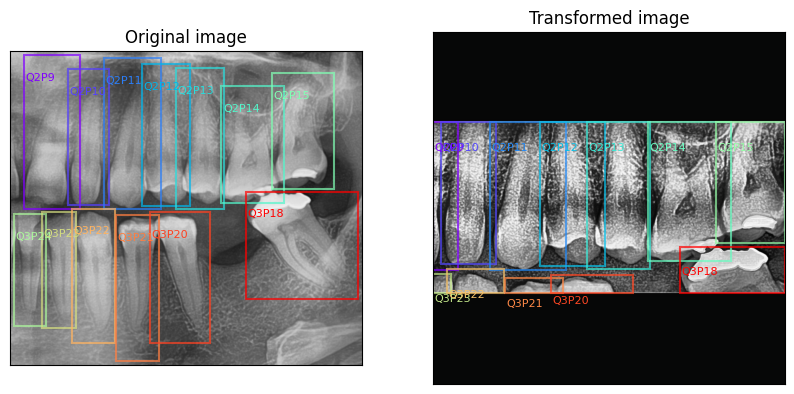

In [44]:
# Plot the last image with bounding boxes
# Making sure it is all correct
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0] = plot_boxes(image=im, box_list=boxes, label_list=label_list, ax=ax[0])
ax[1] = plot_boxes(image=transformed_image, box_list=transformed_box_list, label_list=transformed_label_list, ax=ax[1])
ax[0].set(title='Original image')
ax[1].set(title='Transformed image')
plt.show()